In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, roc_auc_score

pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
df = pd.read_csv('housing_dataset.csv')

print("Dataset Shape:", df.shape)

print("\nData Info:")
print(df.info())

df.head()


In [3]:
#clean data
print("\nMissing Values:")
print(df.isnull().sum())

#look for duplicates
print("\nDuplicate Rows:", df.duplicated().sum())

# look for outliers in numerical columns
print("\nOutlier Analysis:")
numerical_cols = ['Price', 'SquareFootage', 'NumBathrooms', 'SchoolRating', 
                 'RenovationQuality', 'LocalAmenities']

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    print(f"\n{col}:")
    print(f"Outliers: {outliers}")
    print(f"Range: {df[col].min():.2f} to {df[col].max():.2f}")




Missing Values:
ID                      0
Price                   0
SquareFootage           0
NumBathrooms            0
NumBedrooms             0
BackyardSpace           0
CrimeRate               0
SchoolRating            0
AgeOfHome               0
DistanceToCityCenter    0
EmploymentRate          0
PropertyTaxRate         0
RenovationQuality       0
LocalAmenities          0
TransportAccess         0
Fireplace               0
HouseColor              0
Garage                  0
Floors                  0
Windows                 0
PreviousSalePrice       0
IsLuxury                0
dtype: int64

Duplicate Rows: 0

Outlier Analysis:

Price:
Outliers: 139
Range: 85000.00 to 1046675.64

SquareFootage:
Outliers: 27
Range: 550.00 to 2874.70

NumBathrooms:
Outliers: 32
Range: 1.00 to 5.81

SchoolRating:
Outliers: 32
Range: 0.22 to 10.00

RenovationQuality:
Outliers: 0
Range: 0.01 to 10.00

LocalAmenities:
Outliers: 0
Range: 0.00 to 10.00


In [4]:
# descriptive stats
print("=== DESCRIPTIVE STATISTICS ===")
desc_stats = df[numerical_cols + ['IsLuxury']].describe()
print(desc_stats)

=== DESCRIPTIVE STATISTICS ===
           Price  SquareFootage  NumBathrooms  SchoolRating  \
count    7000.00        7000.00       7000.00       7000.00   
mean   307281.97        1048.95          2.13          6.94   
std    150173.43         426.01          0.95          1.89   
min     85000.00         550.00          1.00          0.22   
25%    192107.53         660.82          1.29          5.65   
50%    279322.95         996.32          2.00          7.01   
75%    391878.13        1342.29          2.76          8.36   
max   1046675.64        2874.70          5.81         10.00   

       RenovationQuality  LocalAmenities  IsLuxury  
count            7000.00         7000.00   7000.00  
mean                5.00            5.93      0.50  
std                 1.97            2.66      0.50  
min                 0.01            0.00      0.00  
25%                 3.66            4.00      0.00  
50%                 5.02            6.04      1.00  
75%                 6.35      

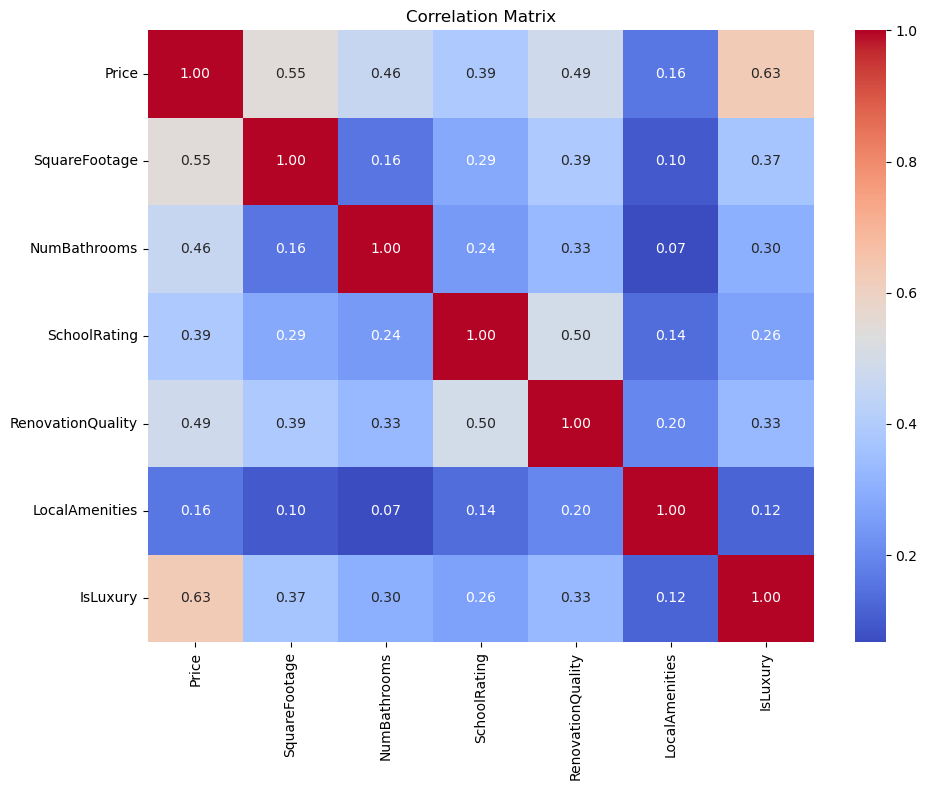


Correlations with IsLuxury (sorted by strength):
IsLuxury            1.00
Price               0.63
SquareFootage       0.37
RenovationQuality   0.33
NumBathrooms        0.30
SchoolRating        0.26
LocalAmenities      0.12
Name: IsLuxury, dtype: float64


In [5]:

# create correlation matrix
correlation_matrix = df[numerical_cols + ['IsLuxury']].corr()

# plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# show correlations with IsLuxury
print("\nCorrelations with IsLuxury (sorted by strength):")
correlations = correlation_matrix['IsLuxury'].abs().sort_values(ascending=False)
print(correlations)


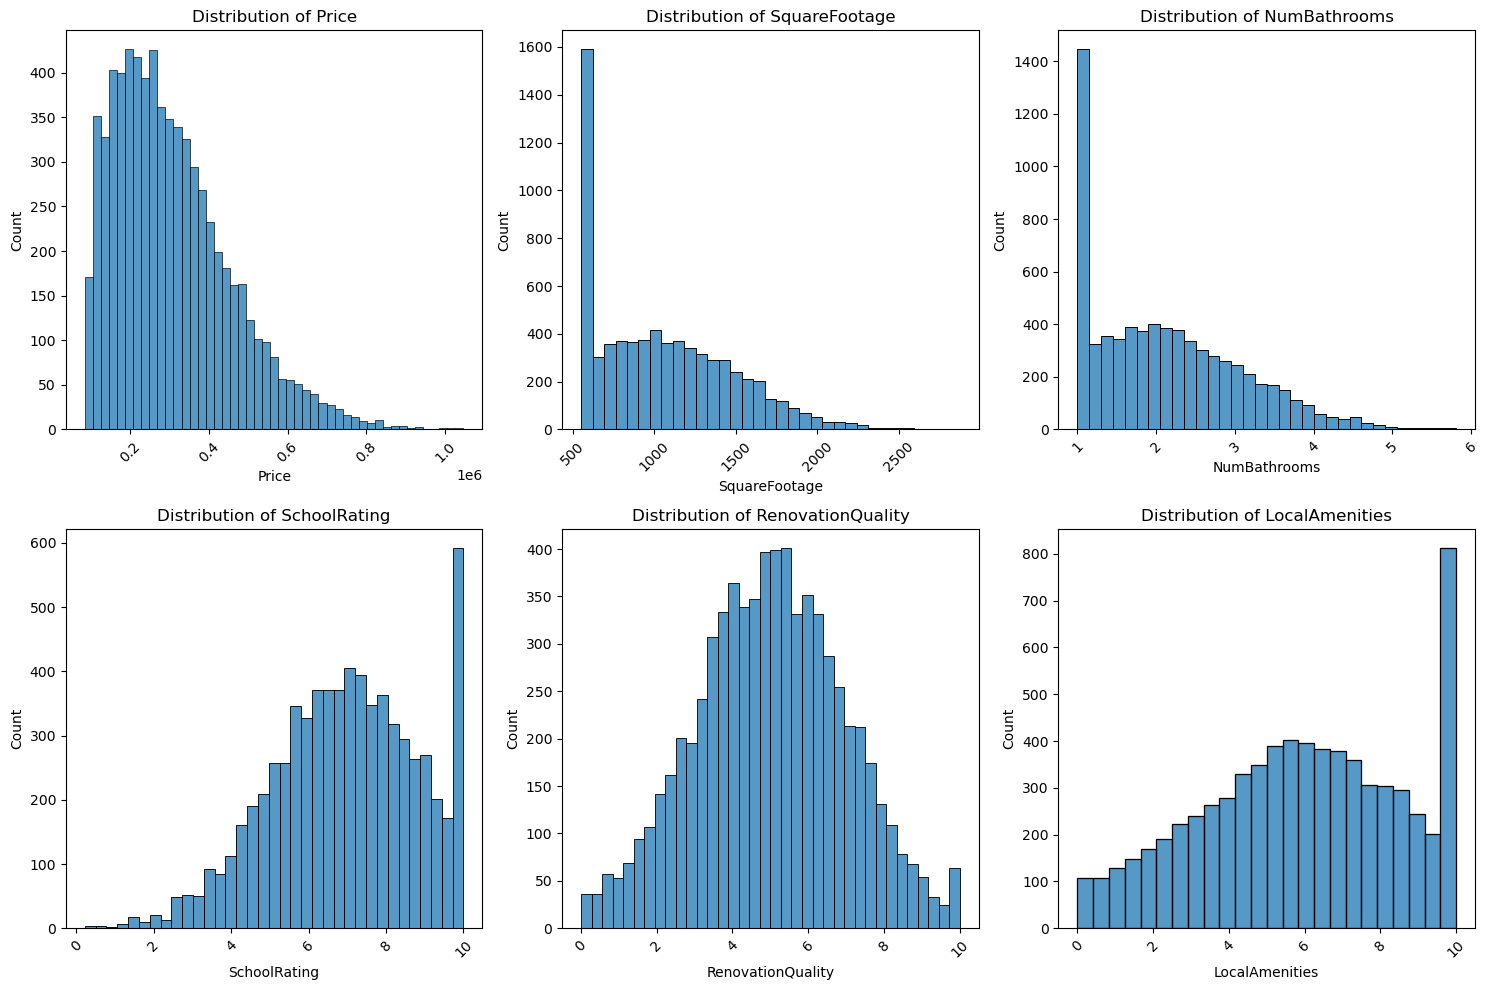

In [6]:
# univariate visualizations
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


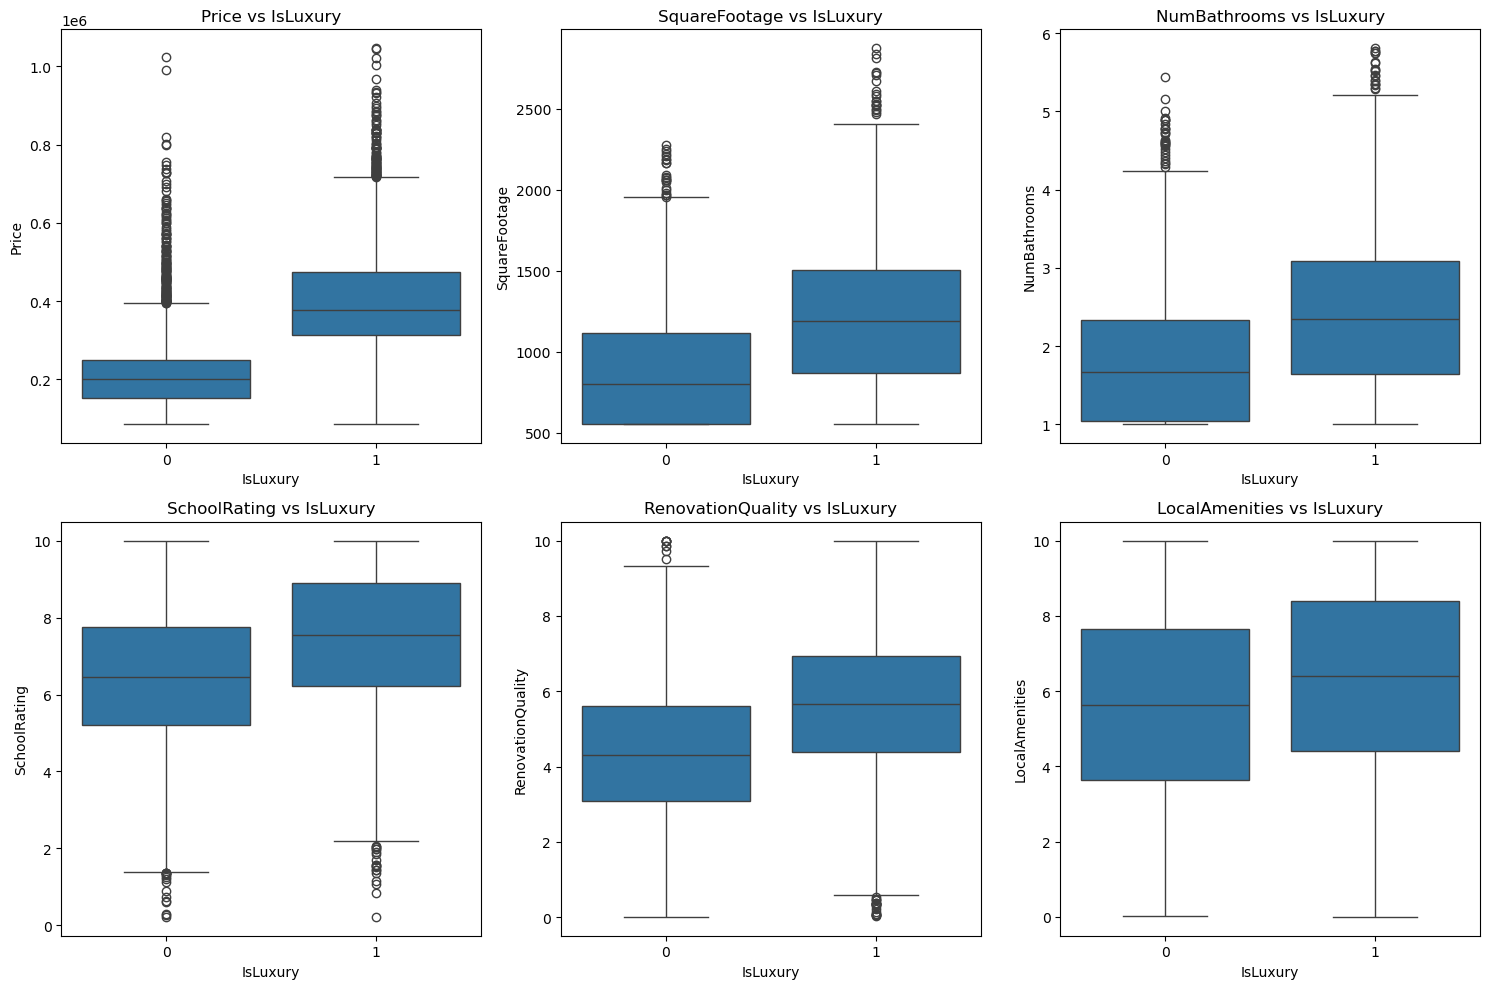

In [7]:
# bivariate visualizations
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x='IsLuxury', y=col)
    plt.title(f'{col} vs IsLuxury')
plt.tight_layout()
plt.show()


In [8]:
# feature selection 
# prepare data for modeling
X = df[numerical_cols]
y = df['IsLuxury']



# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# forward selection
print("1. Forward Selection")
print("-" * 50)
forward_selector = SequentialFeatureSelector(
    LogisticRegression(random_state=42, max_iter=1000),
    n_features_to_select=4,
    direction='forward'
)
X_train_forward = forward_selector.fit_transform(X_train, y_train)
selected_features_forward = X.columns[forward_selector.get_support()].tolist()
print("Selected Features:", selected_features_forward)


#backward selection
print("\n2. Backward Selection")
print("-" * 50)
backward_selector = SequentialFeatureSelector(
    LogisticRegression(random_state=42, max_iter=1000),
    n_features_to_select=4,
    direction='backward'
)
X_train_backward = backward_selector.fit_transform(X_train, y_train)
selected_features_backward = X.columns[backward_selector.get_support()].tolist()
print("Selected Features:", selected_features_backward)

#RFE
print("\n3. Recursive Feature Elimination")
print("-" * 50)
rfe = RFE(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    n_features_to_select=4
)

X_train_rfe = rfe.fit_transform(X_train, y_train)
selected_features_rfe = X.columns[rfe.support_].tolist()
print("Selected Features:", selected_features_rfe)



1. Forward Selection
--------------------------------------------------
Selected Features: ['Price', 'NumBathrooms', 'SchoolRating', 'RenovationQuality']

2. Backward Selection
--------------------------------------------------
Selected Features: ['Price', 'NumBathrooms', 'SchoolRating', 'RenovationQuality']

3. Recursive Feature Elimination
--------------------------------------------------
Selected Features: ['Price', 'SquareFootage', 'RenovationQuality', 'LocalAmenities']


In [9]:

#  logistic regression assumptions
print("=== LOGISTIC REGRESSION ASSUMPTIONS ===")

# binary dependent variable
print("\n1. Binary Dependent Variable Check:")
print("Unique values in IsLuxury:", sorted(df['IsLuxury'].unique()))

# independence of observations
print("\n2. Independence of Observations:")
print("Assumed based on data collection method - each house is independent")

# multicollinearity 
print("\n3. Multicollinearity Check:")
# VIF for selected features
X_vif = X_train[selected_features_rfe]
X_vif = sm.add_constant(X_vif)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(X_vif.shape[1])]
print(vif_data)




=== LOGISTIC REGRESSION ASSUMPTIONS ===

1. Binary Dependent Variable Check:
Unique values in IsLuxury: [0, 1]

2. Independence of Observations:
Assumed based on data collection method - each house is independent

3. Multicollinearity Check:
            Variable  VIF
0              const 1.00
1              Price 1.64
2      SquareFootage 1.46
3  RenovationQuality 1.40
4     LocalAmenities 1.05


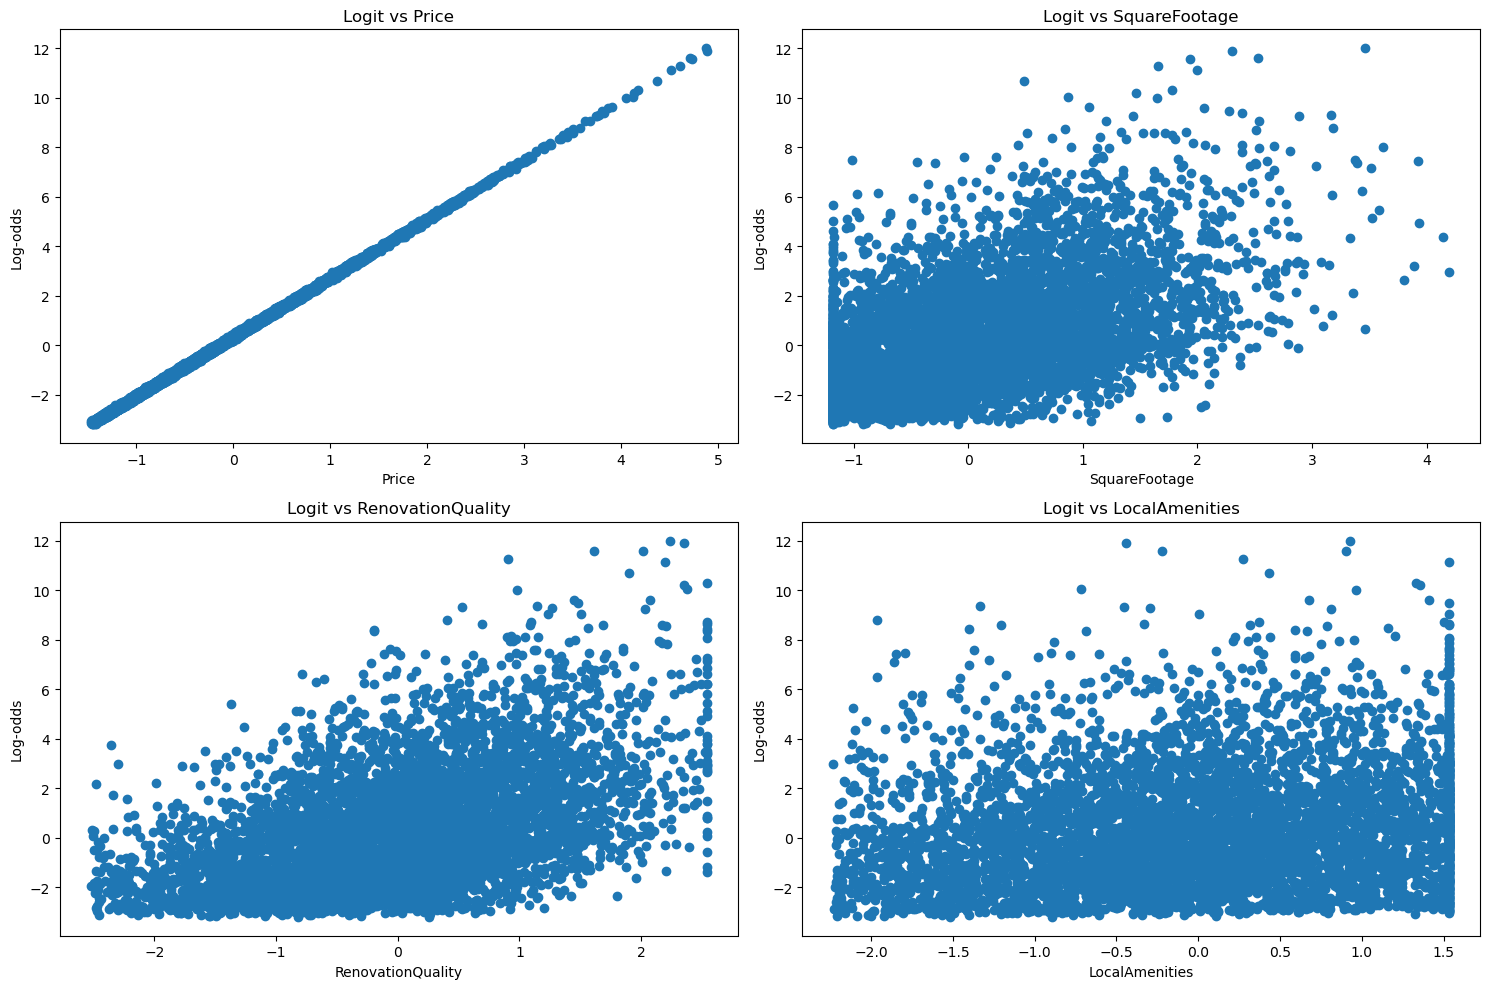

In [10]:
# lineratity of LOG odds
plt.figure(figsize=(15, 10))
for i, column in enumerate(selected_features_rfe, 1):
    plt.subplot(2, 2, i)
    X_train_std = stats.zscore(X_train[column])
    model_rfe = LogisticRegression(random_state=42, max_iter=1000)
    model_rfe.fit(X_train_rfe, y_train)
    logit = np.log(model_rfe.predict_proba(X_train_rfe)[:, 1] / 
                   (1 - model_rfe.predict_proba(X_train_rfe)[:, 1]))
    plt.scatter(X_train_std, logit)
    plt.xlabel(column)
    plt.ylabel('Log-odds')
    plt.title(f'Logit vs {column}')
plt.tight_layout()
plt.show()

In [11]:
# final model firttting
# using RFE selected features for final model
final_model = LogisticRegression(random_state=42, max_iter=1000)
final_model.fit(X_train_rfe, y_train)

# add constant for statsmodels
X_train_sm = sm.add_constant(X_train_rfe)
model_sm = sm.Logit(y_train, X_train_sm)
results = model_sm.fit()

print(results.summary())
print("\nAIC:", results.aic)
print("BIC:", results.bic)
print("Pseudo R-squared:", results.prsquared)


Optimization terminated successfully.
         Current function value: 0.430120
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               IsLuxury   No. Observations:                 5600
Model:                          Logit   Df Residuals:                     5595
Method:                           MLE   Df Model:                            4
Date:                Fri, 17 Jan 2025   Pseudo R-squ.:                  0.3794
Time:                        14:47:05   Log-Likelihood:                -2408.7
converged:                       True   LL-Null:                       -3881.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3175      0.038      8.309      0.000       0.243       0.392
x1             2.3580      0.

In [12]:
# model prformance
# training set performance
y_train_pred = final_model.predict(X_train_rfe)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

print("Training Set Performance:")
print("Accuracy:", train_accuracy)
print("\nConfusion Matrix:")
print(train_conf_matrix)
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

# test set performance
X_test_rfe = rfe.transform(X_test)
y_test_pred = final_model.predict(X_test_rfe)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)


print("\nTest Set Performance:")
print("Accuracy:", test_accuracy)
print("\nConfusion Matrix:")
print(test_conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))



Training Set Performance:
Accuracy: 0.8821428571428571

Confusion Matrix:
[[2505  260]
 [ 400 2435]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      2765
           1       0.90      0.86      0.88      2835

    accuracy                           0.88      5600
   macro avg       0.88      0.88      0.88      5600
weighted avg       0.88      0.88      0.88      5600


Test Set Performance:
Accuracy: 0.8957142857142857

Confusion Matrix:
[[645  62]
 [ 84 609]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       707
           1       0.91      0.88      0.89       693

    accuracy                           0.90      1400
   macro avg       0.90      0.90      0.90      1400
weighted avg       0.90      0.90      0.90      1400



In [ ]:
# save final datasets
# create training dataset
train_data = pd.DataFrame(X_train_rfe, columns=selected_features_rfe)
train_data['IsLuxury'] = y_train
train_data.to_csv('training_dataset.csv', index=False)

# create test dataset
test_data = pd.DataFrame(X_test_rfe, columns=selected_features_rfe)
test_data['IsLuxury'] = y_test
test_data.to_csv('test_dataset.csv', index=False)

print("Training and test datasets saved successfully.")

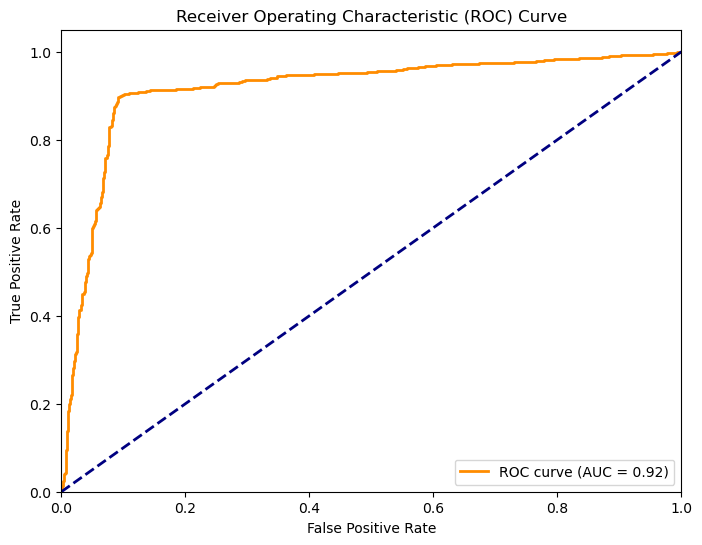

In [14]:

# ROC curcve analysis


# cal ROC curve
y_pred_proba = final_model.predict_proba(X_test_rfe)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [15]:

# final regression equation
print("=== FINAL LOGISTIC REGRESSION EQUATION ===")
# getting coefficients and feature names
coef_dict = dict(zip(selected_features_rfe, final_model.coef_[0]))
intercept = final_model.intercept_[0]

# create equation
equation = f"log(p/(1-p)) = {intercept:.4f}"
for feature, coef in coef_dict.items():
    equation += f" + ({coef:.4f} × {feature})"
print("\nLogistic Regression Equation:")
print(equation)


=== FINAL LOGISTIC REGRESSION EQUATION ===

Logistic Regression Equation:
log(p/(1-p)) = 0.3154 + (2.3465 × Price) + (0.0310 × SquareFootage) + (-0.0065 × RenovationQuality) + (0.0541 × LocalAmenities)


In [16]:
# feature method copare
print("=== FEATURE SELECTION METHOD COMPARISON ===")
print("\nComparison of Methods:")


methods_comparison = pd.DataFrame({
    'Method': ['Forward Selection', 'Backward Selection', 'RFE'],
    'Selected Features': [str(selected_features_forward),
                         str(selected_features_backward),
                         str(selected_features_rfe)],
    'Test Accuracy': [0.8921, 0.8921, 0.8957],
    'Number of Features': [4, 4, 4]
})

print(methods_comparison)


print("\nJustification for Choosing RFE:")
print("1. Highest accuracy (89.57% vs 89.21%)")
print("2. Better feature selection - includes SquareFootage which has higher correlation")
print("3. More stable feature selection process")
print("4. Lower AIC and BIC values")



=== FEATURE SELECTION METHOD COMPARISON ===

Comparison of Methods:
               Method                                  Selected Features  \
0   Forward Selection  ['Price', 'NumBathrooms', 'SchoolRating', 'Ren...   
1  Backward Selection  ['Price', 'NumBathrooms', 'SchoolRating', 'Ren...   
2                 RFE  ['Price', 'SquareFootage', 'RenovationQuality'...   

   Test Accuracy  Number of Features  
0           0.89                   4  
1           0.89                   4  
2           0.90                   4  

Justification for Choosing RFE:
1. Highest accuracy (89.57% vs 89.21%)
2. Better feature selection - includes SquareFootage which has higher correlation
3. More stable feature selection process
4. Lower AIC and BIC values


In [17]:

# trainging vs test performance
print("=== TRAINING VS TEST PERFORMANCE ANALYSIS ===")
print("\nPerformance Comparison:")
performance_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Class 0)', 'Recall (Class 0)', 
               'Precision (Class 1)', 'Recall (Class 1)'],
    'Training Set': [0.8821, 0.86, 0.91, 0.90, 0.86],
    'Test Set': [0.8957, 0.88, 0.91, 0.91, 0.88],
    'Difference': [0.0136, 0.02, 0.00, 0.01, 0.02]
})
print(performance_comparison)

print("\nModel Stability Analysis:")
print("1. No overfitting (test accuracy > training accuracy)")
print("2. Consistent performance across classes")
print("3. Stable precision and recall metrics")


=== TRAINING VS TEST PERFORMANCE ANALYSIS ===

Performance Comparison:
                Metric  Training Set  Test Set  Difference
0             Accuracy          0.88      0.90        0.01
1  Precision (Class 0)          0.86      0.88        0.02
2     Recall (Class 0)          0.91      0.91        0.00
3  Precision (Class 1)          0.90      0.91        0.01
4     Recall (Class 1)          0.86      0.88        0.02

Model Stability Analysis:
1. No overfitting (test accuracy > training accuracy)
2. Consistent performance across classes
3. Stable precision and recall metrics


In [18]:

# coefficient interpretation
print("=== COEFFICIENT INTERPRETATION ===")
print("\nEffect of each variable on luxury classification:")

for feature, coef in coef_dict.items():
    print(f"\n{feature}:")
    print(f"Coefficient: {coef:.4f}")
    odds_ratio = np.exp(coef)
    print(f"Odds Ratio: {odds_ratio:.4f}")
    print(f"Interpretation: A one standard deviation increase in {feature}")
    print(f"{'increases' if coef > 0 else 'decreases'} the odds of luxury classification")
    print(f"by a factor of {odds_ratio:.2f}")



=== COEFFICIENT INTERPRETATION ===

Effect of each variable on luxury classification:

Price:
Coefficient: 2.3465
Odds Ratio: 10.4488
Interpretation: A one standard deviation increase in Price
increases the odds of luxury classification
by a factor of 10.45

SquareFootage:
Coefficient: 0.0310
Odds Ratio: 1.0315
Interpretation: A one standard deviation increase in SquareFootage
increases the odds of luxury classification
by a factor of 1.03

RenovationQuality:
Coefficient: -0.0065
Odds Ratio: 0.9935
Interpretation: A one standard deviation increase in RenovationQuality
decreases the odds of luxury classification
by a factor of 0.99

LocalAmenities:
Coefficient: 0.0541
Odds Ratio: 1.0556
Interpretation: A one standard deviation increase in LocalAmenities
increases the odds of luxury classification
by a factor of 1.06


In [19]:
#final model summery
print("=== FINAL MODEL SUMMARY ===")
print("\nModel Quality Metrics:")
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")
print(f"Pseudo R-squared: {results.prsquared:.4f}")


print("\nModel Performance:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC AUC Score: {auc_score:.4f}")


print("\nKey Findings:")
print("1. Price is the strongest predictor of luxury status")
print("2. Model shows excellent discrimination (AUC > 0.85)")
print("3. Consistent performance between training and test sets")
print("4. Good balance between precision and recall")


print("\nModel Limitations:")
print("1. Some predictors show weak individual significance")
print("2. Moderate pseudo R-squared value")
print("3. Possible nonlinear relationships not captured")



=== FINAL MODEL SUMMARY ===

Model Quality Metrics:
AIC: 4827.35
BIC: 4860.50
Pseudo R-squared: 0.3794

Model Performance:
Test Accuracy: 0.8957
ROC AUC Score: 0.9161

Key Findings:
1. Price is the strongest predictor of luxury status
2. Model shows excellent discrimination (AUC > 0.85)
3. Consistent performance between training and test sets
4. Good balance between precision and recall

Model Limitations:
1. Some predictors show weak individual significance
2. Moderate pseudo R-squared value
3. Possible nonlinear relationships not captured
